# 準備資料

In [1]:
from datetime import datetime
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os 
import json
from io import BytesIO
import base64

In [2]:
exp_name = "gemma3-4b-sft-textonly-" 
'''
本次實驗名稱
textonly:對應dataset/0513_SFTDataset/text/qa_pairs_sft.json，只包含文字問題
hitdata:對應dataset/0513_SFTDataset/hitdata/sft_training_data.json，為圖文對資料
'''

'\ntextonly:對應dataset/0513_SFTDataset/text/qa_pairs_sft.json，只包含文字問題\nhitdata:對應dataset/0513_SFTDataset/hitdata/sft_training_data.json，為圖文對資料\n'

In [3]:
file_locate = "/tmp/pycharm_project_979/" #遠端環境，根據部署地做更改
jsonFile_path = file_locate+"dataset/0513_SFTDataset/text/qa_pairs_sft.json"

with open(jsonFile_path, "r", encoding="utf-8") as f:
    dataset = json.load(f)

In [4]:
print(dataset[0]["messages"][2])

{'role': 'assistant', 'content': '高爾夫球桿由球頭、桿身和握把三部分組合而成。其中，桿身是影響高爾夫球桿功能最重要的部分，主要負責傳遞揮桿力量、影響擊球距離與穩定性。球頭則用於擊球，握把則提供握持的舒適性和控制力。'}


## json內圖片轉換(使用hitdata才需執行)

In [4]:
import base64
from io import BytesIO
from PIL import Image

def base64_to_pil(base64_str: str) -> Image.Image:
    """將 base64 字串轉為 PIL Image"""
    if ',' in base64_str:
        base64_str = base64_str.split(',')[1]
    image_data = base64.b64decode(base64_str)
    return Image.open(BytesIO(image_data))
def compress_image(img: Image.Image, scale_percent: int = 0, quality: int = 85) -> Image.Image:
    """
    根據原圖大小以百分比縮小圖片。
    - scale_percent: 縮小比例（例如 50 表示縮成 50%）
    - quality: JPEG 壓縮品質（1~100）
    回傳縮小並壓縮後的 PIL.Image 物件。
    """
    img = img.convert("RGB")  # 確保轉成 RGB 模式
    width, height = img.size
    new_width = int(width * scale_percent / 100)
    new_height = int(height * scale_percent / 100)
    resized_img = img.resize((new_width, new_height), Image.LANCZOS)

    # 壓縮品質模擬：寫入 buffer 再重新讀入
    buffer = BytesIO()
    resized_img.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    return Image.open(buffer).copy()  # ← 強制 load 到記憶體



def convert_images_in_dataset(dataset):
    """
    將 dataset 中所有 base64 圖片轉換為 PIL.Image，保留原資料結構
    """
    for entry in dataset:
        for message in entry.get("messages", []):
            for content in message.get("content", []):
                if content.get("type") == "image" and isinstance(content.get("image"), str):
                    try:
                        img = base64_to_pil(content["image"])
                        img = compress_image(img, scale_percent=20,quality=50)
                        content["image"] = img
                    except Exception as e:
                        print(e)
                        content["image"] = None  # 或保留原 base64

    return dataset  # 可省略，dataset 是 in-place 修改
daatset = convert_images_in_dataset(dataset)

AttributeError: 'str' object has no attribute 'get'

<PIL.Image.Image image mode=RGB size=1080x384 at 0x7F58611AAE90>


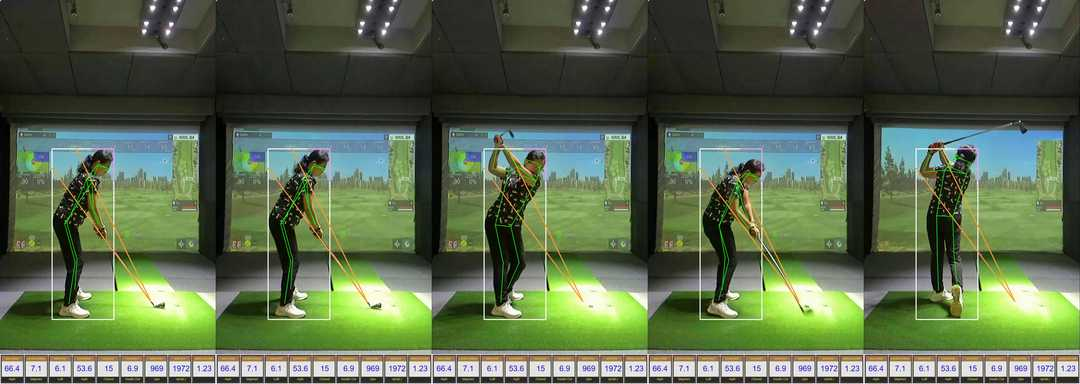

None


In [5]:
img = dataset[0]["messages"][1]["content"][0]["image"]
print(img)
print(img.show())  # 應該會是 <class 'PIL.Image.Image'>

# Training

In [4]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Hugging Face model id
model_id = "google/gemma-3-4b-pt" 

# Check if GPU benefits from bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

# Define model init arguments
model_kwargs = dict(
    attn_implementation="eager", # Use "flash_attention_2" when running on Ampere or newer GPU
    torch_dtype=torch.bfloat16, # What torch dtype to use, defaults to auto
    device_map="auto", # Let torch decide how to load the model
)

# BitsAndBytesConfig int-4 config
model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

# Load model and tokenizer
model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained("google/gemma-3-4b-it",use_fast=True)

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.74s/it]


In [6]:
from trl import SFTConfig

time = datetime.now().strftime("%Y_%m_%d_%H%M")
args = SFTConfig(
    output_dir="model/"+exp_name+time,     # directory to save and repository id
    num_train_epochs=15,                         # number of training epochs
    per_device_train_batch_size=1,              # batch size per device during training
    gradient_accumulation_steps=4,              # number of steps before performing a backward/update pass
    gradient_checkpointing=True,                # use gradient checkpointing to save memory
    optim="adamw_torch_fused",                  # use fused adamw optimizer
    logging_steps=1,                            # log every 5 steps
    logging_dir="logs",
    save_strategy="epoch",                      # save checkpoint every epoch
    learning_rate=1e-5,                         # learning rate, based on QLoRA paper
    bf16=True,                                  # use bfloat16 precision
    max_grad_norm=0.3,                          # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                          # warmup ratio based on QLoRA paper
    lr_scheduler_type="constant",               # use constant learning rate scheduler
    push_to_hub=False,                           # push model to hub
    report_to="wandb",                    
    gradient_checkpointing_kwargs={
        "use_reentrant": False
    },  # use reentrant checkpointing
    dataset_text_field="",                      # need a dummy field for collator
    dataset_kwargs={"skip_prepare_dataset": True},  # important for collator
    run_name=exp_name + time,
)
args.remove_unused_columns = False # important for collator

# Create a data collator to encode text and image pairs
def process_vision_info(messages: list[dict]) -> list[Image.Image]:
    image_inputs = []
    # Iterate through each conversation
    
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(image.convert("RGB"))
    return image_inputs

def collate_fn(examples):# Create a data collator to encode text and image pairs
    """
    1. 檢測每個樣本是否包含圖片
    2. 分別處理有圖片和無圖片的樣本
    3. 只有在有圖片時才處理圖片相關的token
    """
    texts = []
    images = []
    
    for example in examples:
        # 提取圖片
        image_inputs = process_vision_info(example["messages"])
        
        # 生成對話文本
        text = processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )
        texts.append(text.strip())
        
        # 處理圖片：如果沒有圖片則添加None
        if len(image_inputs) == 0:
            images.append(None)
        else:
            images.append(image_inputs)

    # 檢查是否有任何圖片
    has_images = any(img is not None for img in images)
    
    if has_images:
        # 處理圖文對
        processed_images = []
        for img_list in images:
            if img_list is None:
                continue  # 跳過沒有圖片的樣本
            else:
                processed_images.extend(img_list)
        
        # Tokenize the texts and process the images
        batch = processor(
            text=texts, 
            images=processed_images if processed_images else None, 
            return_tensors="pt", 
            padding=True
        )
    else:
        # 純文字處理
        batch = processor(text=texts, images=None, return_tensors="pt", padding=True)

    # The labels are the input_ids, and we mask the padding tokens and image tokens in the loss computation
    labels = batch["input_ids"].clone()
    
    
    # Mask tokens for not being used in the loss computation
    # 只有當有圖片時才處理圖片token
    if has_images and any(img is not None for img in images):
        try:
            # 查找圖片token ID
            if "boi_token" in processor.tokenizer.special_tokens_map:
                image_token_id = processor.tokenizer.convert_tokens_to_ids(
                    processor.tokenizer.special_tokens_map["boi_token"]
                )
                labels[labels == image_token_id] = -100
            
            # 其他圖片相關的token
            labels[labels == 262144] = -100
            
        except (KeyError, AttributeError):
            # 如果沒有圖片相關的特殊token，跳過
            pass
    
    # Mask image tokens
    labels[labels == processor.tokenizer.pad_token_id] = -100

    batch["labels"] = labels
    return batch


In [7]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [8]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset,
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [9]:
import wandb

wandb.init(project="III-2025-golf", name=exp_name+time)#記錄實驗log
trainer.train()
trainer.save_model()

wandb: Currently logged in as: rikurzt (rikurzt-national-chung-hsing-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
1,15.840400
2,15.642200
3,13.590500
4,15.217700
5,14.702900
6,14.144100
7,14.301300
8,14.942400
9,16.475300
10,13.850100


In [11]:
del model
del trainer
torch.cuda.empty_cache()

# Evaluate

In [5]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:

# Load Model with PEFT adapter

model_train_time = "2025_06_20_0842"
model = AutoModelForImageTextToText.from_pretrained(
  file_locate+"model/"+exp_name+model_train_time,
  device_map="cuda:0",
  torch_dtype=torch.bfloat16,
  attn_implementation="eager",
)
processor = AutoProcessor.from_pretrained(file_locate+"model/"+exp_name+model_train_time)

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


In [7]:
import random 

def process_vision_info(messages: list[dict]) -> list[Image.Image]:
    image_inputs = []
    # Iterate through each conversation
    
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(image.convert("RGB"))
    return image_inputs

def eval_model_output_with_csv(model, processor, test_count=5, save_csv=True, output_dir="experiment_result", random_select=True):
    """
    新增參數 random_select: 若為True則隨機選擇資料，否則取前test_count筆資料
    """
    print(f"=== 模型評估：{'隨機' if random_select else '固定前'} {test_count} 筆資料 ===\n")
    
    # 測試樣本選擇邏輯
    dataset_size = len(dataset)
    if random_select:
        test_indices = random.sample(range(dataset_size), min(test_count, dataset_size))
    else:
        test_indices = list(range(min(test_count, dataset_size)))
    
    # 準備儲存結果的列表
    evaluation_results = []
    
    
    for i, idx in enumerate(test_indices):
        print(f"--- 測試樣本 {i+1}/{test_count} (dataset index: {idx}) ---")
        
        # 初始化這次評估的結果字典
        result = {
            'sample_index': idx,
            'test_order': i + 1,
            'data_type': '',
            'question': '',
            'model_response': '',
            'ground_truth': '',
            'evaluation_status': '',
            'error_message': '',
            'response_length': 0,
            'ground_truth_length': 0,
            'evaluation_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        
        try:
            # 獲取測試樣本
            sample = dataset[idx]
            messages = sample["messages"].copy()
            
            # 檢查是否有圖片
            has_image = any(
                isinstance(content, dict) and content.get("type") == "image"
                for msg in messages
                for content in (msg.get("content", []) if isinstance(msg.get("content"), list) else [])
            )
            
            data_type = '多模態 (圖片+文字)' if has_image else '純文字'
            result['data_type'] = data_type
            print(f"資料類型: {data_type}")
            
            # 提取用戶問題
            user_msg = None
            for msg in messages:
                if msg.get("role") == "user":
                    user_msg = msg
                    break
            
            question_text = ""
            if user_msg:
                content = user_msg.get("content", [])
                if isinstance(content, str):
                    question_text = content
                elif isinstance(content, list):
                    text_parts = [c.get("text", "") for c in content if isinstance(c, dict) and c.get("type") == "text"]
                    if text_parts:
                        question_text = text_parts[0]
            
            result['question'] = question_text
            print(f"問題: {question_text[:200]}...")
            
            # 準備推理用的messages（移除assistant回應，添加generation prompt）
            inference_messages = [msg for msg in messages if msg.get("role") != "assistant"]
            
            # 應用聊天模板
            text = processor.apply_chat_template(
                inference_messages, tokenize=False, add_generation_prompt=True
            )
            
            # 處理圖片
            image_inputs = process_vision_info(inference_messages)
            
            # 準備輸入
            inputs = processor(
                text=[text],
                images=image_inputs if image_inputs else None,
                padding=True,
                return_tensors="pt",
            )
            
            # 移動到設備
            inputs = inputs.to(model.device)
            
            # 生成回應
            stop_token_ids = [
                processor.tokenizer.eos_token_id, 
                processor.tokenizer.convert_tokens_to_ids("<end_of_turn>")
            ]
            
            print("模型回應:")
            with torch.no_grad():
                generated_ids = model.generate(
                    **inputs, 
                    max_new_tokens=512, 
                    top_p=0.95, 
                    do_sample=True, 
                    temperature=0.7, 
                    eos_token_id=stop_token_ids, 
                    disable_compile=True,
                    pad_token_id=processor.tokenizer.eos_token_id
                )
            
            # 解碼輸出
            generated_ids_trimmed = [
                out_ids[len(in_ids):] 
                for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
            ]
            
            output_text = processor.batch_decode(
                generated_ids_trimmed, 
                skip_special_tokens=True, 
                clean_up_tokenization_spaces=False
            )[0]
            
            result['model_response'] = output_text
            result['response_length'] = len(output_text)
            print(f"{output_text}\n")
            
            # 提取真實答案
            assistant_msg = None
            for msg in messages:
                if msg.get("role") == "assistant":
                    assistant_msg = msg
                    break
            
            if assistant_msg:
                true_answer = assistant_msg.get("content", "")
                if isinstance(true_answer, list):
                    true_answer = " ".join([c.get("text", "") for c in true_answer if isinstance(c, dict)])
                result['ground_truth'] = true_answer
                result['ground_truth_length'] = len(true_answer)
                print(f"標準答案: {true_answer[:300]}...")
            
            result['evaluation_status'] = 'SUCCESS'
            print("=" * 80)
            
        except Exception as e:
            result['evaluation_status'] = 'ERROR'
            result['error_message'] = str(e)
            print(f"處理樣本 {idx} 時出錯: {e}")
            print("=" * 80)
        
        # 將結果添加到列表中
        evaluation_results.append(result)
    
    # 儲存結果到CSV
    if save_csv and evaluation_results:
        # 確保輸出目錄存在
        os.makedirs(output_dir, exist_ok=True)
        
        # 生成文件名
        timestamp = datetime.now().strftime("%Y_%m_%d_%H%M")
        csv_file_name = f"model_evaluation_result_{timestamp}.csv"
        csv_path = os.path.join(output_dir, csv_file_name)
        
        # 創建DataFrame並儲存
        df = pd.DataFrame(evaluation_results)
        df.to_csv(csv_path, index=False, encoding='utf-8-sig')
    
    
    return evaluation_results


In [8]:

# 執行帶有CSV儲存功能的模型評估
results = eval_model_output_with_csv(
    model=model, 
    processor=processor, 
    test_count=5,           # 測試10筆資料
    save_csv=True,           # 儲存到CSV
    output_dir="experiment_result/0513_Dataset_FineTune",  # 輸出目錄
    random_select=False
)


=== 模型評估：固定前 5 筆資料 ===

--- 測試樣本 1/5 (dataset index: 0) ---
資料類型: 純文字
問題: 高爾夫球桿的主要組成部分有哪些？它們各自的功能是什麼？...
模型回應:
高爾夫球桿主要由桿頭、桿頸和桿身三部分組成。桿身是影響球桿性能最重要的部分，主要功能包括傳遞手腕力量、控制球的飛行距離和方向。桿頸則固定在握把與桿頭之間，決定球桿的穩定性和方向，並影響揮桿的穩定性。桿頭則是球與桿接觸的部位，決定擊球的彈道和準確度。

標準答案: 高爾夫球桿由球頭、桿身和握把三部分組合而成。其中，桿身是影響高爾夫球桿功能最重要的部分，主要負責傳遞揮桿力量、影響擊球距離與穩定性。球頭則用於擊球，握把則提供握持的舒適性和控制力。...
--- 測試樣本 2/5 (dataset index: 1) ---
資料類型: 純文字
問題: 請解釋一下影響高爾夫球桿擊球距離與穩定性的桿身因素有哪些？...
模型回應:
影響高爾夫球桿擊球距離與穩定性的桿身因素包括：揮桿時的桿身重量傳遞與回饋，桿身的彎曲程度、硬度、扭力以及曲折點位置。這些因素會影響擊球的彈道、準確性和控制力。

標準答案: 影響高爾夫球桿擊球距離與穩定性的桿身因素包括曲折點（彎曲點或擊點）、軟硬度、扭力、重量、長度、揮桿重量以及桿身脊線（spine）等。這些因素會影響桿身的彎曲行為、揮桿感受和擊球效果。...
--- 測試樣本 3/5 (dataset index: 2) ---
資料類型: 純文字
問題: 如果一名高爾夫球手的桿頭速度較快，是否可以推斷他適合較硬的桿身？...
模型回應:
是的，研究顯示，桿頭速度較快的球手通常較適合較硬的桿身（如200比尼氏硬度），因為較硬的桿身能產生更高的球速和較少的彈性回正力矩。

標準答案: 是的，使用者桿頭速度較快時，通常較適合較硬的桿身。因為較硬的桿身能更有效地傳遞力量，並且在高速揮桿下能提供更好的控制和穩定性。...
--- 測試樣本 4/5 (dataset index: 3) ---
資料類型: 純文字
問題: 能否舉例說明桿身硬度如何影響擊球效果？...
模型回應:
當然。桿身硬度較硬的X硬桿身能產生較高的桿頭速度，這使得擊球更穩定且距離較遠，適合技術較高的高爾夫愛好者。而較軟的L軟桿身則適合揮桿速度較慢的球手，能提供較多的彈